**In this analysis, game data from a total of 2559 regular season NFL games covering a span of ten years from 2010-2019 is considered, obtained from http://pro-football-reference.com. The aim of this regression analysis is to predict the total points in a given NFL contest based on game conditions and statistics from the participating teams averaged over the previous six games. Only contests taking place from the seventh week of the season to the last week of the regular season are considered for prediction, totalling 1734 games. A description of the features used in this analysis follows.**

**Descriptive Features** - Used solely to describe the contest in question
 * Home_Team - The name of the home team in the contest
 * Vis_Team - The name of the visiting team in the contest
 * H_Game - The number of points scored by the home team in the contest
 * V_Game - The number of points scored by the visiting team in the contest
 
**Analytical Features** - Features used in analysis
 * Tot_Pts - Total Points of the contest. **This is our target variable.**
 * Over/Under - The predicted total points of the contest from professional bookmakers.
 
*Averaged Features* - Statistics averaged over previous five contests. In the columns, prefix "H_" stands for Home Team and "V_" stands for Visiting Team
 * Pts - Points scored
 * Pts_Opp - Points scored by opponent
 * Off_Pass - Offensive passing yards
 * Pass_Metric - Average of offensive passing rank (32 - best, 1 - worst) and defensive passing rank of opponent (1 - best, 32 - worst)
 * Off_Rush - Offensive rushing yards
 * Rush_Metric - Average of offensive rushing rank and defensive rushing rank of opponent
 * Def_Pass - Passing yards given up on defensive
 * Def_Rush - Rushing yards given up on defensive
 * TD - Touchdowns scored
 * TD_on_Def - Touchdowns scored by defense
 * FG_Pct - Percentage of field goals made vs. field goals attempted
 * RZ_Pct - Percentage of red zone possessions resulting in a touchdown (red zone possession is possession reaching opponent's 20 yard line)
 * Def_RZ_Pct - Defensive percentage of red zone possessions giving up a touchdown
 * Poss - Time of possession
 * Plays - Total number of plays
 * TO_Gain - Number of turnovers gained by defense
 * TO_Lost - Number of turnovers lost by offense
 * Yds_Pen - Number of yards penalized
 * Sacks_Def - Sacks earned by defense
 * Tackles_Loss - Number of tackles for loss earned by defense
 * Kickret - Return yards from kickoff
 * Puntret - Return yards from punt
 
*Game Conditions* - Conditions of the contest in question
 * Temperature - Temperature of the contest at kickoff
 * surface - The surface on which the contest was played

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [430]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
sns.set(font_scale=1.4)

In [8]:
teams = {'Atlanta Falcons':'atl','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi',
         'Cincinnati Bengals':'cin','Cleveland Browns':'cle','Indianapolis Colts':'clt',
         'Arizona Cardinals':'crd','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det',
         'Green Bay Packers':'gnb','Houston Texans':'htx','Jacksonville Jaguars':'jax',
         'Kansas City Chiefs':'kan','Miami Dolphins':'mia','Minnesota Vikings':'min','New Orleans Saints':'nor',
         'New England Patriots':'nwe','New York Giants':'nyg','New York Jets':'nyj','Tennessee Titans':'oti',
         'Philadelphia Eagles':'phi','Pittsburgh Steelers':'pit','Oakland Raiders':'rai',
         'Las Vegas Raiders':'rai','St. Louis Rams':'ram','Los Angeles Rams':'ram','Baltimore Ravens':'rav',
         'San Diego Chargers':'sdg','Los Angeles Chargers':'sdg','Seattle Seahawks':'sea',
         'San Francisco 49ers':'sfo','Tampa Bay Buccaneers':'tam','Washington Redskins':'was'}

In [418]:
num = 6 # number of games averaged over

In [10]:
def combine_dummies(df, name, combine_cols):
    for col in combine_cols:
        ind=df[df[col]==1].index
        df.loc[ind,name] = col
        df.drop(col,axis=1,inplace=True)
    return df

In [ ]:
path = 'data/df_raw.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)
dfall

In [419]:
path = 'data/df_working'+str(num)+'.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)

In [420]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_show = dfgame.copy(deep=False)
y = np.ravel(dfgame['Tot_Pts'])
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# 15%, 15% split for validation, test data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio))
X_show = X_show.loc[X_train.index]

In [47]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**The barplot demonstrates the quantized nature of football scoring. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

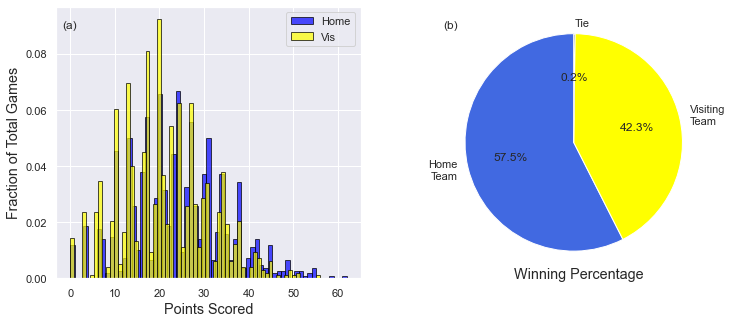

In [212]:
scores = X_show[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,color='blue',ec='black',alpha=0.7,
         label='Home')
_ = plt.hist(scores['Vis'],bins=63,density=True,color='yellow',ec='black',alpha=0.7,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('royalblue','yellow','black')
_ = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
_ = plt.text(0.28,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()
fig1.savefig('plots/fig1.png',bbox_inches='tight')

**We can see the range of total score is much larger than that of the Over/Under (3X) with a positive correlation of 0.28.**

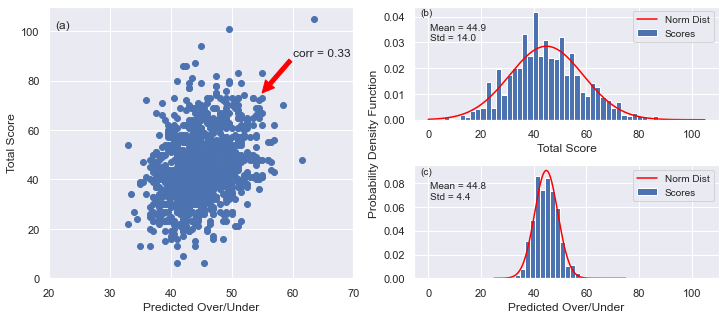

In [223]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
#sns.lmplot(x='Over/Under',y='Tot_Pts',data=X_show)
ax.scatter(X_show['Over/Under'],X_show['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
ax.annotate('corr = 0.33',xy=(55,75),xytext=(60,90),arrowprops={'color':'red'},fontsize='medium')
ax.text(0.02,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(X_show['Tot_Pts'])
sig = np.std(X_show['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(X_show['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='small')
ax0.text(0.02,0.92,'(b)',transform=ax0.transAxes,fontsize='small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(X_show['Over/Under'])
sig = np.std(X_show['Over/Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(X_show['Over/Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(X_show['Over/Under']),scale=np.std(X_show['Over/Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='small')
ax1.text(0.02,0.92,'(c)',transform=ax1.transAxes,fontsize='small')
fig2.add_subplot(ax1)
fig2.text(0.495,0.30,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

In [225]:
error = X_show['Tot_Pts'] - X_show['Over/Under']

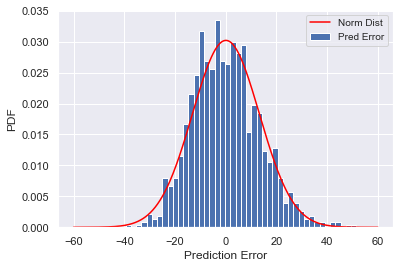

In [226]:
mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig3 = plt.figure()
_ = fig3.add_subplot(1,1,1)
_ = plt.xlabel('Prediction Error')
_ = plt.ylabel('PDF')
_ = plt.hist(error,bins=44,density=True,label='Pred Error')
_ = plt.plot(xx,yy,color='red',label='Norm Dist')
_ = plt.legend(loc='upper right',fontsize='small')
fig3.show()
fig3.savefig('plots/fig3.png',bbox_inches='tight')

**This boxplot shows the symmetry of the error data around 0 and the larger number of positive outliers in the Over/Under prediction error.** 

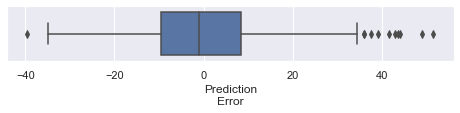

In [227]:
fig4 = plt.figure(figsize=(8,1))
error = pd.Series(error,name='Prediction'+'\n'+'Error')
_ = sns.boxplot(error, orient='h')
fig4.show()
fig4.savefig('plots/fig4.png',bbox_inches='tight')

**There is remarkable symmetry in the Over/Under prediction error, as well as in the Over vs. Under wins. This symmetry is also revealed in the median error, although a greater number of outliers to the upside is reflected in the average error.** 

The median and average errors for the Over are 9.2 and 11.3 points
The median and average errors for the Under are -9.0 and -10.2 points


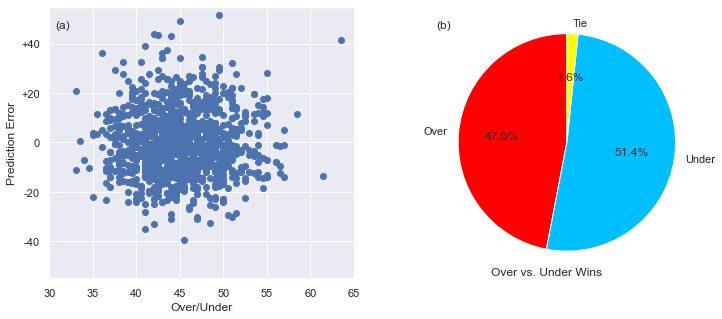

In [228]:
import matplotlib.ticker as tick
fig5, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5)) 
error = X_show['Tot_Pts'] - X_show['Over/Under']
ax1.set_ylim(-55,55)
ax1.set_xlim(30,65)
ax1.set_xlabel('Over/Under')
ax1.set_ylabel('Prediction Error')
ax1.scatter(X_show['Over/Under'],error)
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
o_u = np.array([(X_show['Tot_Pts'] > X_show['Over/Under']).sum(),
                (X_show['Tot_Pts'] < X_show['Over/Under']).sum(),
                 (X_show['Tot_Pts'] == X_show['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax2.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax2.text(0.22,0.01,'Over vs. Under Wins',transform=ax2.transAxes)
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.show()
fig5.savefig('plots/fig5.png',bbox_inches='tight')
import statistics
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

In [231]:
Q3=error.quantile(0.75)
Q1=error.quantile(0.25)
IQR = Q3-Q1
outliers = X_show.loc[error > 1.5*IQR,:]
outlier_year = pd.Series([int(x[0:4]) for x in outliers.index])
year_counts = outlier_year.value_counts().sort_index()

In [229]:
# Calculate percentage of 'Overs' by year 
year = pd.DataFrame([int(x[0:4]) for x in X_show.index],index=X_show.index)
year['Over'] = X_show['Tot_Pts'] > X_show['Over/Under']
over_count = year['Over'].groupby(year.iloc[:,0]).mean()

**There is no particular pattern with respect to number of outlier games and the year from the bar chart. Furthermore, the Over winning percentage is not constant by year, as shown in the line plot. However, there does seem to be some correlation between the Over winning percentage and the number of outlier games.** 

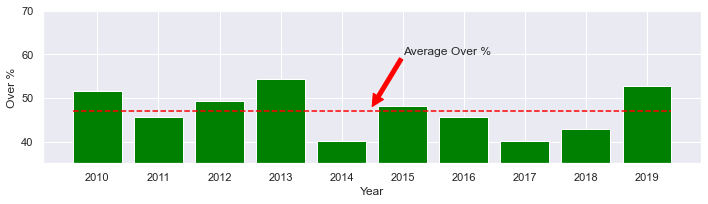

In [232]:
fig6 = plt.figure(figsize=(10,3))
_ = fig6.add_subplot(1,1,1)
_ = plt.xlabel('Year')
_ = plt.ylabel('Over %')
_ = plt.bar(year_counts.index,over_count.values*100,color='green',
       tick_label=[str(i) for i in range(2010,2020)])
_ = plt.ylim(35,70)
_ = plt.hlines(47.0,2009.6,2019.4,linestyle='dashed',colors='red')
_ = plt.annotate('Average Over %',xy=(2014.5,48),xytext=(2015,60),arrowprops={'color':'red'})
#ax2 = ax.twinx()
#ax2.set_ylabel('Number of Outlier Games')
#ax2.plot(over_count.index,over_count.values*100,linewidth=1, color='blue')
fig6.tight_layout()  
fig6.show()
fig6.savefig('plots/fig6.png')

In [15]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

**Examining the upside outlier games further, these games seem to be populated by certain scenarios. Here is a bar plot demonstrating the difference between the mean outlier value and the general mean value as a fraction of the general standard deviation for the categories in our dataset. Games that are poorly predicted to the upside seem to have some of the following characteristics in our dataset:**
 * Home teams having strong pass offenses, particularly those combined with weak visiting pass defenses, as reflected in "H_Pass_Metric" 
 * Home teams with a strong tendency to obtain turnovers
 * Home teams with high red zone percentages against teams with low red zone percentages
 * Visiting teams with penchant for incurring penalties

**The following correlation matrix reveals that there seems to be a much greater correlation between the scoring history of the teams and the predicted over/under (0.45,0.46) than between the scoring history and the actual total score of the predicted game (0.14,0.13). In addition, there is little to no correlation between the opposing teams' scores of the last five games and the total score of the game in question (0.00,0.05). Also revealed is that there is significant correlation between red zone percentage and scoring history, as expected, but little correlation with scoring history and field goal percentage. The importance of red zone percentage is reflected in the over/under prediction, but less so in the actual total score.**

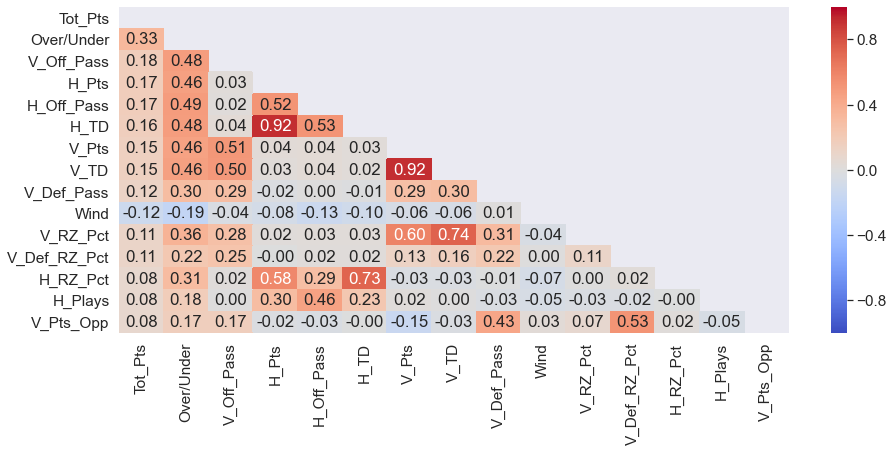

In [570]:
fig7 = plt.figure(figsize=(15,6))
ax = fig7.add_subplot(1,1,1)

cols = X_show.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
cols = cols.drop(['a_turf','astroplay','astroturf','fieldturf','grass','matrixturf','sportturf'])
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = X_show[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
#_ = plt.text(0.95,0.92,'(a)',transform=ax.transAxes,fontsize='medium')
fig7.show()
fig7.savefig('plots/fig7.png')

In [456]:
X_show['Tot_Pts'].corr(X_show['H_Def_RZ_Pct'])

0.051472387657170736

In [457]:
X_show['Over/Under'].corr(X_show['H_Def_RZ_Pct'])

0.20440976755338705

In [542]:
X_show = X_show.drop(['H_TD','V_TD'],axis=1)

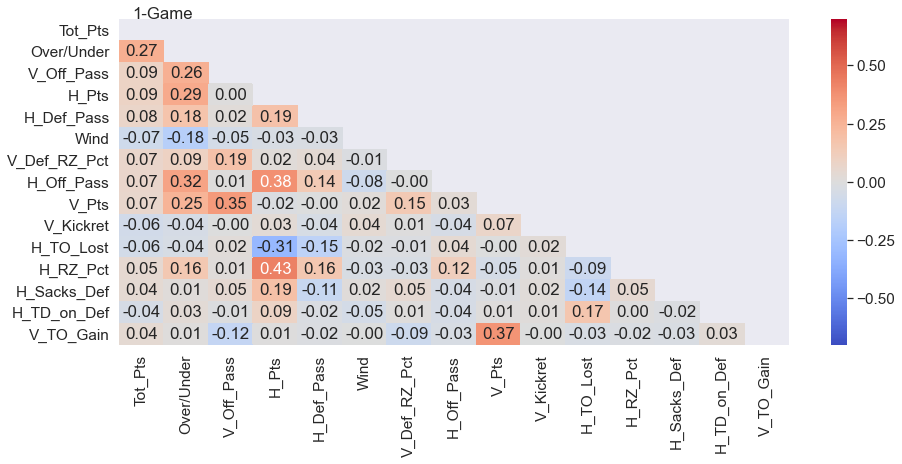

In [543]:
fig8 = plt.figure(figsize=(15,6))
ax = fig8.add_subplot(1,1,1)

cols = X_show.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
cols = cols.drop(['a_turf','astroplay','astroturf','fieldturf','grass','matrixturf','sportturf'])
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = X_show[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.02,1.00,str(num)+'-Game',transform=ax.transAxes)
fig8.show()
file = 'plots/fig8_'+str(num)+'.png'
fig8.savefig(file)

In [1080]:
X_show[X_show['Humidity'] > 0].Temperature.min()

-8.60381222818219

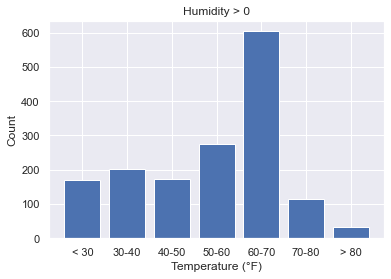

In [1086]:
bins = [-10,30,40,50,60,70,80,100]
grouped = X_show.groupby(pd.cut(X_show.Temperature,bins))
ind = np.arange(len(grouped['Temperature'].count()))
_ = plt.bar(ind,grouped['Temperature'].count().values)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.xlabel('Temperature (°F)')
_ = plt.ylabel('Count')
_ = plt.title('Humidity > 0')
plt.show()

In [1082]:
len(X_show[((X_show['Humidity']>0) & (X_show['Temperature']>78))])

35

In [1084]:
X_show[X_show['Humidity']>0].Temperature.max()

87.0

In [1085]:
X_show['Tot_Pts'].corr(X_show['Humidity'])

-0.03779842797685108

In [1087]:
X_show[X_show['Humidity']>0]['Tot_Pts'].corr(X_show['Humidity'])

-0.035195131739074556

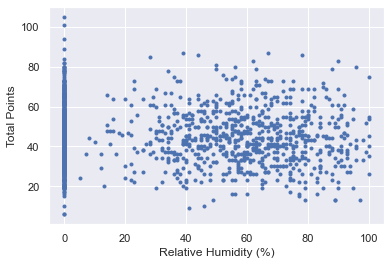

In [1089]:
_ = plt.plot(X_show['Humidity'],X_show['Tot_Pts'],marker='.',linestyle='None')
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
plt.show()

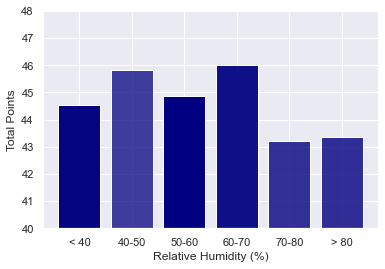

In [1105]:
bins = [0,40,50,60,70,80,100]
grouped = X_show.groupby(pd.cut(X_show.Humidity,bins))
counts = grouped['Tot_Pts'].count().values
alp = counts/max(counts)
colors = [(0,0,0.5,alp[a]) for a in range(len(alp))]
ind = np.arange(len(grouped['Humidity'].mean()))
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color=colors)
_ = plt.xticks(ind,labels=('< 40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
plt.show()

In [1106]:
grouped['Tot_Pts'].count()

Humidity
(0, 40]      140
(40, 50]     106
(50, 60]     143
(60, 70]     134
(70, 80]     114
(80, 100]    115
Name: Tot_Pts, dtype: int64

In [396]:
X_show['Tot_Pts'].corr(X_show['Temperature'])

0.06450947290353899

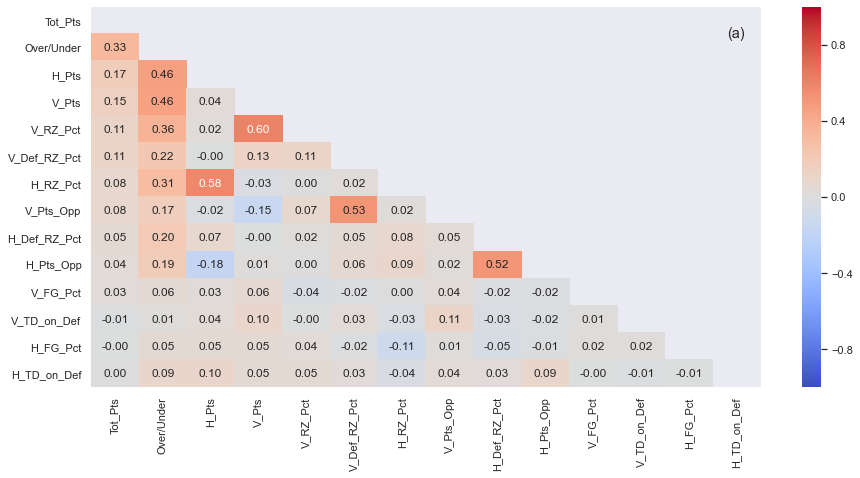

In [618]:
fig9a = plt.figure(figsize=(15,7))
ax = fig9a.add_subplot(1,1,1)

cols=['Over/Under','Tot_Pts','H_Pts','H_Pts_Opp','V_Pts','V_Pts_Opp','H_TD_on_Def','V_TD_on_Def',
      'H_RZ_Pct','V_RZ_Pct','H_Def_RZ_Pct','V_Def_RZ_Pct','H_FG_Pct','V_FG_Pct']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Points = X_show[newcols]
mask = np.triu(Points.corr())
sns.heatmap(Points.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.95,0.92,'(a)',transform=ax.transAxes,fontsize='large')
fig9a.show()
fig9a.savefig('plots/fig9a.png')

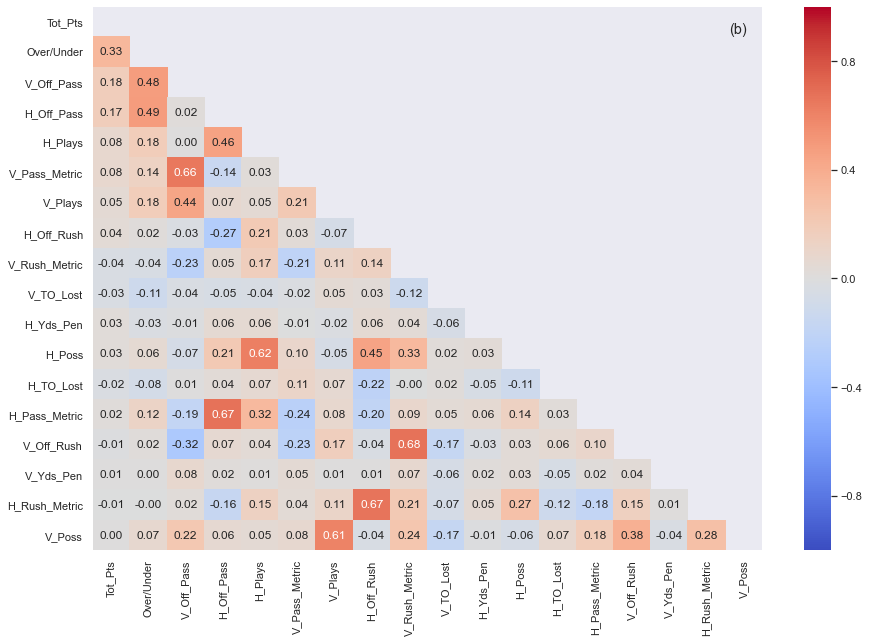

In [617]:
fig9b = plt.figure(figsize=(15,10))
ax = fig9b.add_subplot(1,1,1)

cols=['Over/Under','Tot_Pts','H_Off_Pass','H_Pass_Metric','V_Off_Pass',
              'V_Pass_Metric','H_Off_Rush','H_Rush_Metric','V_Off_Rush',
              'V_Rush_Metric','H_TO_Lost','V_TO_Lost','H_Yds_Pen','V_Yds_Pen',
              'H_Poss','V_Poss','H_Plays','V_Plays']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Ostats=X_show[newcols]
mask = np.triu(Ostats.corr())
sns.heatmap(Ostats.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.95,0.95,'(b)',transform=ax.transAxes,fontsize='large')
fig9b.show()
fig9b.savefig('plots/fig9b.png')

In [370]:
X_show['H_Pts'].corr(X_show['H_Pass_Metric'])

0.3432109770983537

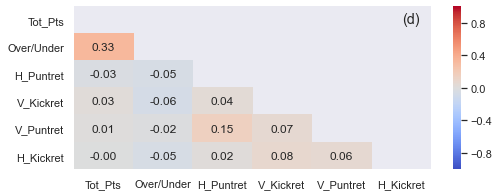

In [615]:
fig9d = plt.figure(figsize=(8,3))
ax = fig9d.add_subplot(1,1,1)

cols=['Tot_Pts','Over/Under','H_Kickret','V_Kickret',
              'H_Puntret','V_Puntret']
corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Sstats=X_show[newcols]
mask = np.triu(Sstats.corr())
sns.heatmap(Sstats.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
_ = plt.text(0.92,0.90,'(d)',transform=ax.transAxes,fontsize='large')
fig9d.show()
fig9d.savefig('plots/fig9d.png')

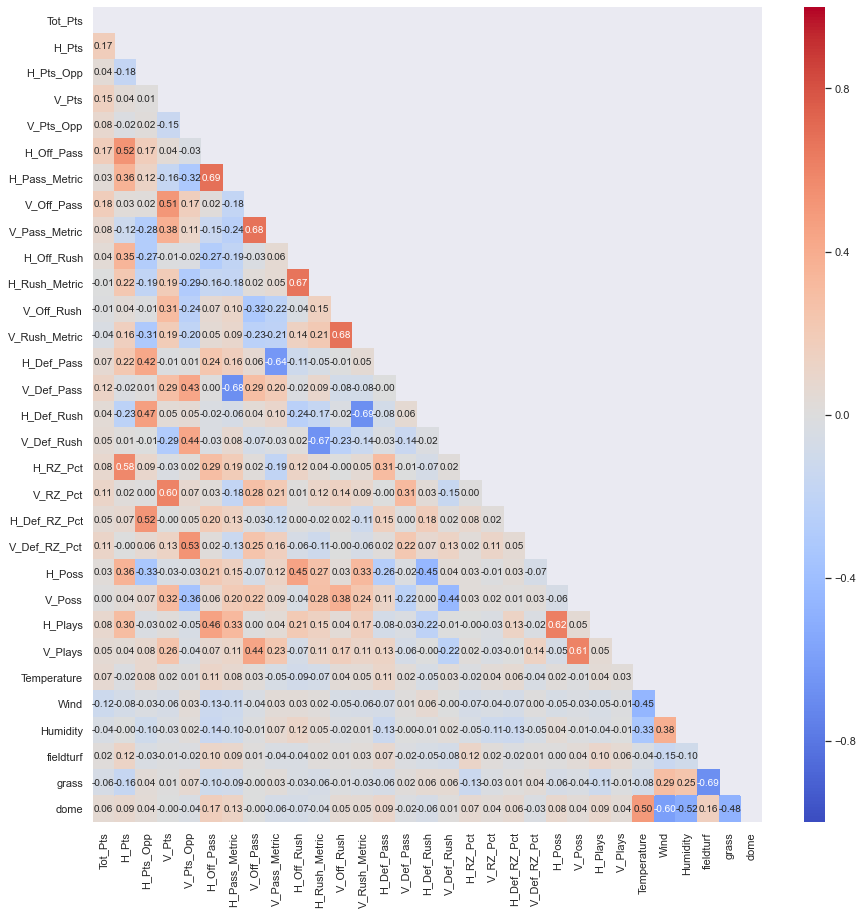

In [130]:
fig9 = plt.figure(figsize=(15,15))
ax = fig9.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over/Under']
                 
cols=X_show.columns.drop(dropped)
#corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
#sortcorr = sorted(corrs,reverse=True)
#mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
#newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Stats=X_show[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.4: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
#sns.set(font_scale=0.8)
sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig9.show()
fig9.savefig('plots/fig9.png')

In [48]:
reg_score=np.empty(7)
for n in range(1,8):
    path = 'data/df_working'+str(n)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = np.ravel(dfgame['Tot_Pts'])
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    LR = linear_model.LinearRegression()
    LR.fit(XX_train,yy_train)
    reg_score[n-1] = LR.score(XX_train,yy_train)

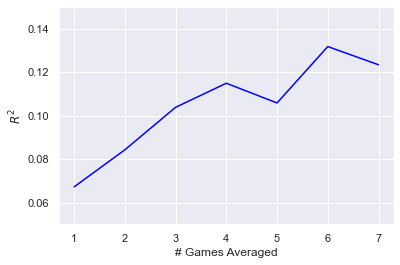

In [233]:
fig8 = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel(r'$R^2$')
_ = plt.ylim(0.05,0.15)
_ = plt.plot(np.arange(1,len(reg_score)+1),reg_score,color='blue')
fig8.show()
fig8.savefig('plots/fig8.png')

In [938]:
fitt = LR.fit(X_train,y_train)
fitt.score(X_train,y_train)

0.14915943015424948

In [51]:
standard = StandardScaler()
minmax = MinMaxScaler()
standX = standard.fit_transform(X_train)
minmaxX = minmax.fit_transform(X_train)

In [1128]:
s_scalefit = LR.fit(standX,y_train)
s_scalefit.score(standX,y_train)

0.1483286979613443

In [1129]:
coef = pd.DataFrame(abs(LR.coef_), X_train.drop('astroturf',axis=1).columns, columns=['LR Coefficient'])
print(coef.sort_values('LR Coefficient',ascending=False))

                LR Coefficient
Over/Under            3.478065
V_Def_Rush            1.809451
V_Off_Pass            1.519665
Wind                  1.320427
V_Pass_Metric         1.159711
H_Pts                 1.151711
H_Sacks_Def           1.052358
H_Pass_Metric         0.981866
V_Pts_Opp             0.912753
H_Def_Pass            0.904192
V_Def_RZ_Pct          0.855182
V_Kickret             0.815231
H_Off_Pass            0.761754
H_Yds_Pen             0.756845
V_Tackles_Loss        0.750569
H_RZ_Pct              0.741703
H_TD_on_Def           0.714379
H_Poss                0.693194
astroplay             0.635621
H_Def_Rush            0.635125
H_Rush_Metric         0.588819
H_Plays               0.573441
matrixturf            0.534591
H_FG_Pct              0.513879
V_TO_Lost             0.476381
V_Def_Pass            0.432907
V_Puntret             0.384988
V_TD_on_Def           0.372004
V_RZ_Pct              0.353023
V_Sacks_Def           0.349479
Humidity              0.328976
H_Tackle

In [1130]:
m_scalefit = LR.fit(minmaxX,y_train)
m_scalefit.score(minmaxX,y_train)

0.1483286979613443

In [1132]:
coef = pd.DataFrame(abs(LR.coef_), X_train.drop('astroturf',axis=1).columns, columns=['LR Coefficient'])
print(coef.sort_values('LR Coefficient',ascending=False))

                LR Coefficient
Over/Under           24.107577
Wind                 14.893054
V_Def_Rush           13.098342
V_Off_Pass            9.516627
H_Pts                 7.232671
H_Sacks_Def           6.425871
H_RZ_Pct              5.885610
H_Def_Pass            5.847252
V_Pass_Metric         5.573622
V_Kickret             5.556378
V_Def_RZ_Pct          5.535509
V_Pts_Opp             5.241911
V_Tackles_Loss        5.098323
H_Yds_Pen             4.878810
H_Pass_Metric         4.532445
H_Plays               4.450826
H_Off_Pass            4.430785
H_TD_on_Def           4.333602
astroplay             4.261186
H_Def_Rush            4.204836
H_Poss                4.146540
H_FG_Pct              3.349632
matrixturf            3.227463
V_TO_Lost             3.197579
V_Puntret             2.857839
H_Rush_Metric         2.787234
V_Def_Pass            2.573735
V_RZ_Pct              2.265321
V_TD_on_Def           2.251874
V_Sacks_Def           2.124295
H_Tackles_Loss        2.038949
H_Puntre

In [1133]:
small = X_train[['Over/Under','Wind','V_Def_Rush','H_Off_Pass','H_Pass_Metric','H_Pts','H_Sacks_Def','H_RZ_Pct',
                'V_Kickret','V_Def_RZ_Pct','V_Pts_Opp','H_Yds_Pen','V_Tackles_Loss','H_TD_on_Def','V_Off_Pass',
                 'H_Def_Rush','H_FG_Pct','V_TO_Lost','grass','matrixturf','sportturf','a_turf',
                 'fieldturf','astroplay']]
sm_scaled = standard.fit_transform(small)
sm_fit = LR.fit(sm_scaled,y_train)
sm_fit.score(sm_scaled,y_train)

0.14053097199206233

In [1134]:
coef = pd.DataFrame(abs(LR.coef_), small.columns, columns=['LR Coefficient'])
print(coef.sort_values('LR Coefficient',ascending=False))

                LR Coefficient
Over/Under            3.573925
H_Pass_Metric         1.457394
V_Def_Rush            1.254956
H_Off_Pass            1.106676
Wind                  1.096408
H_Pts                 1.073010
V_Pts_Opp             1.014099
H_Sacks_Def           0.963988
V_Kickret             0.853448
V_Def_RZ_Pct          0.819047
H_Def_Rush            0.817123
H_Yds_Pen             0.789234
H_RZ_Pct              0.778170
V_Tackles_Loss        0.752868
H_TD_on_Def           0.658578
astroplay             0.632070
V_Off_Pass            0.620272
matrixturf            0.542683
H_FG_Pct              0.495060
V_TO_Lost             0.389244
sportturf             0.126179
grass                 0.054357
a_turf                0.054356
fieldturf             0.014841


In [1135]:
scaled = standard.fit_transform(small)
fit = LR.fit(scaled,y_train)
y_pred = LR.predict(scaled)
results1 = pd.DataFrame(y_train,columns=['Actual'],index=X_train.index)
results1['Predicted'] = y_pred
results1['Over/Under'] = X_train['Over/Under']
# Results for small number of features
accuracy1 = (((results1['Actual']>results1['Over/Under']) & (results1['Predicted']>results1['Over/Under'])) | 
 ((results1['Actual']<results1['Over/Under']) & (results1['Predicted']<results1['Over/Under']))).mean()
print(fit.score(scaled,y_train),accuracy1)

0.14053097199206233 0.5510018214936248


In [1143]:
# Results for all features
standX = standard.fit_transform(X_train.drop('astroturf',axis=1))
s_scalefit = LR.fit(standX,y_train)
y_pred = LR.predict(standX)
results2 = pd.DataFrame(y_train,columns=['Actual'],index=X_train.index)
results2['Predicted'] = y_pred
results2['Over/Under'] = X_train['Over/Under']
# Results for small number of features
accuracy2 = ((((results2['Actual']>results2['Over/Under']) & (results2['Predicted']>results2['Over/Under'])) | 
 ((results2['Actual']<results2['Over/Under']) & (results2['Predicted']<results2['Over/Under']))).sum()/
             (results2['Actual']!=results2['Over/Under']).sum())
print(s_scalefit.score(standX,y_train),accuracy2)

0.1483286979613443 0.5611111111111111


In [1144]:
under_yes = ((results2['Actual']<results2['Over/Under']) & (results2['Predicted']<results2['Over/Under'])).sum()
under = (results2['Actual']<results2['Over/Under']).sum()
print(under_yes,under,under_yes/under)

311 564 0.5514184397163121


In [1145]:
over_yes = ((results2['Actual']>results2['Over/Under']) & (results2['Predicted']>results2['Over/Under'])).sum()
over = (results2['Actual']>results2['Over/Under']).sum()
print(over_yes,over,over_yes/over)

295 516 0.5717054263565892


In [1146]:
extr=results2[np.abs(results2['Predicted']-results2['Over/Under']) >= 2.0]
len(extr)/len(results2)

0.4899817850637523

In [1147]:
(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()/
 (extr['Actual']<extr['Over/Under']).sum())
print(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum(),
      (extr['Actual']<extr['Over/Under']).sum(),(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()/
 (extr['Actual']<extr['Over/Under']).sum()))

166 276 0.6014492753623188


In [1148]:
(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()/
(extr['Actual']>extr['Over/Under']).sum())
print(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum(),
     (extr['Actual']>extr['Over/Under']).sum(),(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()/
(extr['Actual']>extr['Over/Under']).sum()))

161 254 0.6338582677165354


In [1153]:
len(X_test.columns)

54

In [1154]:
dr=X_test.drop('astroturf',axis=1)
stand_test = standard.transform(dr)
s_scalefit = LR.fit(standX,y_train)
y_pred = LR.predict(stand_test)
results3 = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results3['Predicted'] = y_pred
results3['Over/Under'] = X_test['Over/Under']
# Results for small number of features
accuracy3 = ((((results3['Actual']>results3['Over/Under']) & (results3['Predicted']>results3['Over/Under'])) | 
 ((results3['Actual']<results3['Over/Under']) & (results3['Predicted']<results3['Over/Under']))).sum()/
             (results3['Actual']!=results3['Over/Under']).sum())
print(s_scalefit.score(stand_test,y_test),accuracy3)

0.10063754757216016 0.5108225108225108


In [1155]:
extr=results3[np.abs(results3['Predicted']-results3['Over/Under']) >= 3.0]
len(extr)/len(results3)

0.3093220338983051

In [1156]:
(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()/
 (extr['Actual']<extr['Over/Under']).sum())
print(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum(),
      (extr['Actual']<extr['Over/Under']).sum(),(((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()/
 (extr['Actual']<extr['Over/Under']).sum()))

21 35 0.6


In [1157]:
(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()/
(extr['Actual']>extr['Over/Under']).sum())
print(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum(),
     (extr['Actual']>extr['Over/Under']).sum(),(((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()/
(extr['Actual']>extr['Over/Under']).sum()))

17 35 0.4857142857142857


In [1124]:
cols=['Wind','V_Def_Rush','H_Off_Pass','H_Pass_Metric','H_Pts','H_Sacks_Def','H_RZ_Pct',
                'V_Kickret','V_Def_RZ_Pct','V_Pts_Opp','H_Yds_Pen','V_Tackles_Loss','H_TD_on_Def','V_Off_Pass',
                 'H_Def_Rush','H_FG_Pct','V_TO_Lost','grass','matrixturf','sportturf','a_turf',
                 'fieldturf','astroplay']

small_train = X_train[cols]
small_test = X_test[cols]
scaled_train = standard.fit_transform(small_train)
scaled_test = standard.transform(small_test)                                
LR.fit(scaled_train,y_train)
#y_pred = LR.predict(scaled_test)
#results10 = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
#results10['Over/Under'] = X_test['Over/Under']
y_pred = LR.predict(scaled_train)
results10 = pd.DataFrame(y_train,columns=['Actual'],index=X_train.index)
results10['Over/Under'] = X_train['Over/Under']
results10['Predicted'] = y_pred
# Results for small number of features
accuracy10 = ((((results10['Actual']>results10['Over/Under']) & (results10['Predicted']>results10['Over/Under'])) | 
 ((results10['Actual']<results10['Over/Under']) & (results10['Predicted']<results10['Over/Under']))).sum()/
             (results10['Actual']!=results10['Over/Under']).sum())
print(LR.score(scaled_train,y_train),accuracy10)

0.1145308702961283 0.5638888888888889


In [1125]:
coef = pd.DataFrame(abs(LR.coef_), small_train.columns, columns=['LR Coefficient'])
print(coef.sort_values('LR Coefficient',ascending=False))

                LR Coefficient
H_Off_Pass            2.635257
H_Pts                 2.140616
H_Pass_Metric         2.129602
V_Off_Pass            1.986946
Wind                  1.444731
V_Def_Rush            1.441626
H_Def_Rush            1.287946
V_Def_RZ_Pct          1.013816
V_Pts_Opp             0.872638
matrixturf            0.806129
V_Kickret             0.781540
H_Yds_Pen             0.756889
H_Sacks_Def           0.752050
H_RZ_Pct              0.678299
astroplay             0.617203
H_TD_on_Def           0.595974
V_Tackles_Loss        0.506679
H_FG_Pct              0.423835
sportturf             0.333541
a_turf                0.152395
V_TO_Lost             0.115464
fieldturf             0.090641
grass                 0.033461


In [453]:
scaled_train = standard.fit_transform(X_train)
scaled_test = standard.transform(X_test)                                
LR.fit(scaled_train,y_train)
y_pred = LR.predict(scaled_test)
results15 = pd.DataFrame(y_test,columns=['Actual'],index=X_test.index)
results15['Over/Under'] = dfgame.loc[X_test.index]['Over/Under']
results15['Predicted'] = y_pred
# Results for small number of features
over_c = ((results15['Actual']>results15['Over/Under']) & (results15['Predicted']>results15['Over/Under'])).sum()
over_t = (results15['Predicted']>results15['Over/Under']).sum()
under_c = ((results15['Actual']<results15['Over/Under']) & (results15['Predicted']<results15['Over/Under'])).sum()
under_t = (results15['Predicted']<results15['Over/Under']).sum()
accuracy15 = (over_c+under_c)/(over_t+under_t)
#print(mean_squared_error(y_test,y_pred,squared=False),accuracy15)
print(np.sqrt(mean_squared_error(y_test,y_pred)),accuracy15)

12.960256973215595 0.5635593220338984


In [454]:
o_u = dfgame.loc[X_test.index,'Over/Under'].values
print(np.sqrt(mean_squared_error(y_test,o_u)))

12.942383729830047


In [468]:
Over = dfgame[dfgame.loc[(results15['Predicted'] > results15['Over/Under']).index]]

ValueError: Boolean array expected for the condition, not object

In [466]:
dfgame.loc[(results15['Predicted'] > results15['Over/Under'])]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [462]:
dfgame

,Home_Team,Vis_Team,H_Game,V_Game,Over/Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Wind,Humidity,a_turf,astroplay,fieldturf,grass,matrixturf,sportturf,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201011070atl,Atlanta Falcons,Tampa Bay Buccaneers,27.0,21.0,45.5,48.0,26.666667,19.666667,19.833333,24.833333,...,0.0,0,0,0,1,0,0,0,9,1
201011110atl,Atlanta Falcons,Baltimore Ravens,26.0,21.0,44.0,47.0,24.333333,22.000000,25.833333,19.166667,...,0.0,0,0,0,1,0,0,0,10,1
201011210ram,St. Louis Rams,Atlanta Falcons,17.0,34.0,43.5,51.0,17.166667,19.166667,24.166667,21.500000,...,0.0,0,0,1,0,0,0,0,11,1
201011280atl,Atlanta Falcons,Green Bay Packers,20.0,17.0,48.0,37.0,27.166667,22.000000,24.333333,12.166667,...,0.0,0,0,0,1,0,0,0,12,1
201012050tam,Tampa Bay Buccaneers,Atlanta Falcons,24.0,28.0,43.5,52.0,23.166667,18.666667,27.166667,23.166667,...,9.0,53,0,0,0,1,0,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910200sea,Seattle Seahawks,Baltimore Ravens,16.0,30.0,49.0,46.0,27.500000,24.333333,30.666667,23.333333,...,8.0,79,0,0,1,0,0,0,7,0
201912010rav,Baltimore Ravens,San Francisco 49ers,20.0,17.0,45.0,37.0,37.500000,13.166667,30.833333,16.500000,...,13.0,91,0,0,0,1,0,0,13,0
201911030sea,Seattle Seahawks,Tampa Bay Buccaneers,40.0,34.0,51.0,74.0,26.500000,25.000000,29.833333,30.166667,...,6.0,66,0,0,1,0,0,0,9,0


In [456]:
Under = results15['Predicted']<results15['Over/Under']

In [457]:
Under

Code
201812090sfo     True
201811110phi     True
201811040car    False
201712170car     True
201911240buf     True
                ...  
201701010oti     True
201610230mia     True
201111270nyj     True
201112040htx    False
201101020htx     True
Length: 236, dtype: bool

In [449]:
exam.head(10)

,actual,predicted,O_U
Code,,,
201812090sfo,34.0,45.364508,45.5
201811110phi,47.0,44.334959,45.5
201811040car,70.0,55.700896,55.5
201712170car,55.0,43.467514,46.5
201911240buf,23.0,35.397707,37.0
201111070phi,54.0,49.997093,47.5
201612080kan,34.0,46.431038,46.0
201411160ram,29.0,38.252744,51.0
201012190rai,62.0,55.018598,42.0


In [452]:
np.sqrt(mean_squared_error(y_test[0:10],ou[0:10]))

13.658330791132569

In [ ]:
np.sqrt(mean_squared_error(y_test[0:10],y_pred[0:10]))

In [55]:
coef = pd.DataFrame(LR.coef_, X_train.columns, 
                    columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
coef.iloc[ind]

,LR Coefficient
V_Off_Pass,2.420616
V_Def_Rush,2.144203
H_Off_Pass,2.118869
H_Pts,2.069466
Wind,-1.643816
H_Pass_Metric,-1.316924
H_Def_Rush,1.147316
V_Pass_Metric,-1.062237
H_Sacks_Def,0.994742
V_Def_RZ_Pct,0.978753


In [174]:
extr=results15[np.abs(results15['Predicted']-results15['Over/Under']) >= 3.0]
print(len(extr)/len(results15))
under_c = ((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()
under_t = (extr['Actual']<extr['Over/Under']).sum()
over_c = ((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()
over_t = (extr['Actual']>extr['Over/Under']).sum()
print(under_c,under_t,under_c/under_t)
print(over_c,over_t,over_c/over_t)
print(under_c+over_c,under_t+over_t,(under_c+over_c)/(under_t+over_t))

0.4180327868852459
145 236 0.614406779661017
140 216 0.6481481481481481
285 452 0.6305309734513275


In [1296]:
LR.intercept_

45.488821138211385

In [ ]:
by_home = pd.DataFrame(index=teams.keys())
by_home = by_home.drop('Las Vegas Raiders')
grouped_by_home = X_show.groupby(X_show['Home_Team'])
for key, item in grouped_by_home:
    by_home.loc[key,'Avg_Total_Points'] = item.Tot_Pts.mean()
    by_home.loc[key,'Std_Total_Points'] = item.Tot_Pts.std()
    by_home.loc[key,'Avg_Passing_Yds'] = item.H_Off_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Yds'] = item.H_Off_Rush.mean()
    by_home.loc[key,'Avg_Passing_Def'] = item.H_Def_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Def'] = item.H_Def_Rush.mean()
by_home['Avg_Total_Yds'] = by_home['Avg_Passing_Yds'] + by_home['Avg_Rushing_Yds']
by_home['Avg_Total_Def'] = by_home['Avg_Passing_Def'] + by_home['Avg_Rushing_Def']
by_home['Passing_Rank'] = by_home['Avg_Passing_Yds'].rank(ascending=False)
by_home['Rushing_Rank'] = by_home['Avg_Rushing_Yds'].rank(ascending=False)
by_home['Offense_Rank'] = by_home['Avg_Total_Yds'].rank(ascending=False)
by_home['Passing_Def_Rank'] = by_home['Avg_Passing_Def'].rank(ascending=False)
by_home['Rushing_Def_Rank'] = by_home['Avg_Rushing_Def'].rank(ascending=False)
by_home['Defense_Rank'] = by_home['Avg_Total_Def'].rank(ascending=False)
by_home = by_home.drop(['Avg_Passing_Yds','Avg_Rushing_Yds','Avg_Total_Yds',
                        'Avg_Passing_Def','Avg_Rushing_Def','Avg_Total_Def'],axis=1)

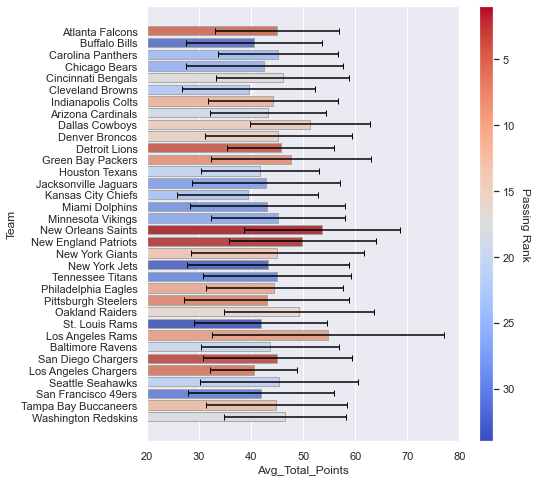

In [104]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
_ = plt.xlabel('Average Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(20,80)
category = list(by_home.index)
sns.set(font_scale=1.0)
sns.barplot(x=by_home['Avg_Total_Points'],y=category,edgecolor='darkgray',
            palette=colors_from_values(by_home['Passing_Rank'],'coolwarm_r'))
plt.errorbar(by_home['Avg_Total_Points'],category,xerr=by_home['Std_Total_Points'],color='black',linestyle='None',capsize=3)
sm = ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(34,1))
sm.set_array([])
cbar = plt.colorbar(sm,label='Passing Rank',aspect=30)
cbar.ax.invert_yaxis()
cbar.set_label('Passing Rank',rotation=270,labelpad=15)
fig.show()
fig.savefig('plots/fig99.png')


In [789]:
by_home['Passing_Rank'].corr(by_home['Avg_Total_Points'])

-0.5210525886928965

In [790]:
by_home['Rushing_Rank'].corr(by_home['Avg_Total_Points'])

-0.006615500915268446

In [791]:
by_home['Total_Rank'].corr(by_home['Avg_Total_Points'])

-0.48376556276867017

In [794]:
by_home['Passing_Def_Rank'].corr(by_home['Avg_Total_Points'])

-0.4347977271282208

In [795]:
by_home['Rushing_Def_Rank'].corr(by_home['Avg_Total_Points'])

-0.003995185113021996

In [798]:
by_home['Defense_Rank'].corr(by_home['Avg_Total_Points'])

-0.3469432262707415

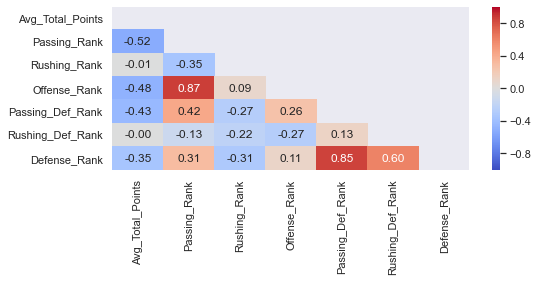

In [817]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1)

mask = np.triu(by_home.corr())
sns.heatmap(by_home.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            cmap='coolwarm',annot=True,fmt='.2f')
fig.show()
fig.savefig('plots/fig98.png')

In [374]:
avg_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).mean()
avg_temp_week = by_week['Temperature'].groupby(by_week['Week']).mean()

NameError: name 'by_week' is not defined

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

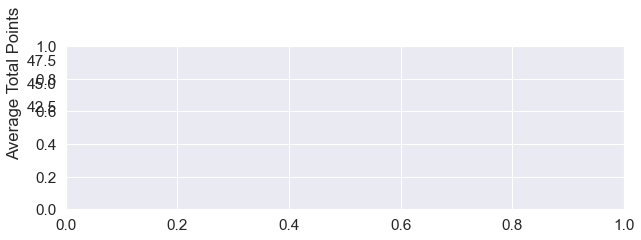

In [830]:
fig9 = plt.figure(figsize=(10,3))
_ = fig9.add_subplot(2,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(41,49)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(7,18)])
#ax2 = ax.twinx()
#ax2.set_ylabel('Temperature (°F)')
#ax2.set_ylim(50,70)
#ax2.plot(avg_temp_week.index,avg_temp_week.values,linewidth=1, color='blue')
_ = fig9.add_subplot(1,1,1)
_ = plt.bar()
fig9.tight_layout()  
fig9.show()

In [665]:
X_show['Tot_Pts'].corr(X_show['Temperature'])

0.060583849681406454

In [678]:
domed = X_show[X_show['dome' == 1]]
notdomed = X_show[X_show['dome' == 0]]

In [1187]:
X_show['Tot_Pts'].corr(X_show['dome'])

0.048973873004645986

In [724]:
temp = notdomed[['Tot_Pts','Temperature']]
#bins = [i for i in range(0,91,10)]
#bins.remove(10)
bins = [-10,30,40,50,60,70,80,100]
grouped = temp.groupby(pd.cut(temp.Temperature,bins))
ind = np.arange(len(grouped['Tot_Pts'].mean()))
print(grouped['Tot_Pts'].mean(),grouped['Tot_Pts'].count())
type(grouped['Tot_Pts'].mean())

Temperature
(-10, 30]    43.544118
(30, 40]     43.178808
(40, 50]     44.786325
(50, 60]     44.984043
(60, 70]     45.909836
(70, 80]     44.426667
(80, 100]    43.052632
Name: Tot_Pts, dtype: float64 Temperature
(-10, 30]    136
(30, 40]     151
(40, 50]     117
(50, 60]     188
(60, 70]     122
(70, 80]      75
(80, 100]     19
Name: Tot_Pts, dtype: int64


pandas.core.series.Series

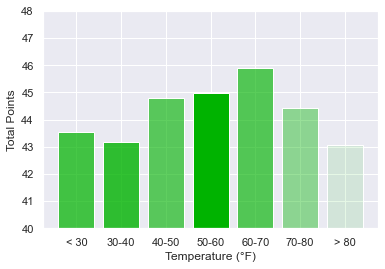

In [818]:
ind = np.arange(len(grouped['Tot_Pts'].mean()))
counts = grouped['Tot_Pts'].count().values
alp = counts/max(counts)
colors = [(0,0.7,0,alp[a]) for a in range(len(alp))]
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color=colors)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Temperature (°F)')
_ = plt.ylabel('Total Points')
plt.show()
fig.savefig('plots/fig97.png')

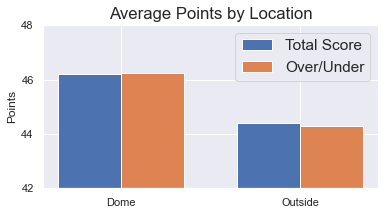

In [372]:
tpmean = (domed['Tot_Pts'].mean(), notdomed['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),notdomed['Over/Under'].mean())

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside'))
_ = plt.legend(loc='upper right')
_ = plt.ylim(42,48)
fig.show()
fig.savefig('plots/fig96.png')

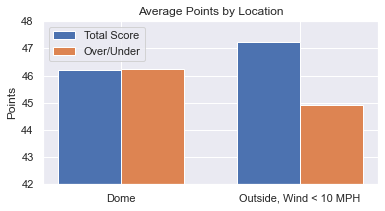

In [385]:
tpmean = (domed['Tot_Pts'].mean(), notdomed.loc[notdomed['Wind'] < 5,'Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),notdomed.loc[notdomed['Wind'] < 5,'Over/Under'].mean())

fig95 = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars

sns.set(font_scale=1.0)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside, Wind < 10 MPH'))
_ = plt.legend(loc='upper left')
_ = plt.ylim(42,48)
fig.show()
len(notdomed.loc[notdomed['Wind'] < 10]),len(notdomed.loc[notdomed['Wind'] < 10])
fig95.savefig('plots/fig96.png')

In [ ]:
len()

NameError: name 'avg_pts_week' is not defined

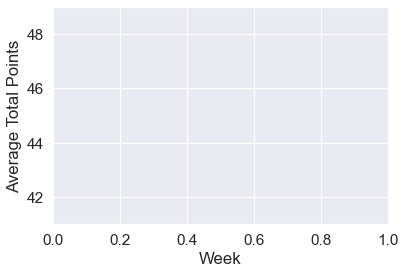

In [373]:
d = [domed['Tot_Pts'].mean(),domed['Over/Under'].mean()]
nd = [notdomed['Tot_Pts'].mean(),notdomed['Over/Under'].mean()]
_ = fig9.add_subplot(2,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(41,49)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(6,18)])

In [705]:
notdomed['Tot_Pts'].corr(notdomed['Temperature'])

0.04175134613588856

In [714]:
notdomed['Tot_Pts'].corr(notdomed['Temperature']**(0.5))

0.056523605587800195

In [703]:
test = notdomed[notdomed['Temperature']<65]
test['Tot_Pts'].corr(test['Temperature'])

0.06161124098270196

In [702]:
test = notdomed[notdomed['Temperature']>=65]
test['Tot_Pts'].corr(test['Temperature'])

-0.10142750464523927

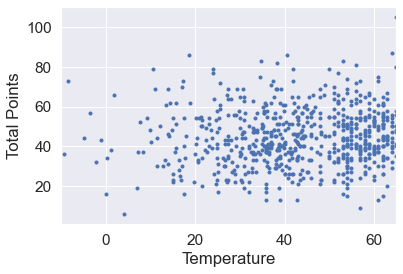

In [694]:
_ = plt.plot(notdomed['Temperature'],notdomed['Tot_Pts'],marker='.',linestyle="None")
_ = plt.xlim(-10,65)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Total Points')
plt.show()

In [382]:
X_show['Wind'].describe()

count    1098.000000
mean        6.310565
std         6.297769
min         0.000000
25%         0.000000
50%         6.000000
75%        10.000000
max        71.000000
Name: Wind, dtype: float64

In [664]:
X_show[X_show['Wind']==71]

,Home_Team,Vis_Team,H_Game,V_Game,Tot_Pts,Over/Under,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Temperature,Wind,a_turf,astroplay,astroturf,fieldturf,grass,matrixturf,sportturf,Week
Code,,,,,,,,,,,,,,,,,,,,,
201612040pit,Pittsburgh Steelers,New York Giants,24.0,14.0,38,49.5,21.166667,21.5,23.666667,17.5,...,28.113559,71.0,0,0,0,0,1,0,0,13


In [1213]:
surf_cols=['a_turf','astroplay','fieldturf','grass','matrixturf','sportturf']
X_show['astroturf'] = 1-X_show[surf_cols].sum(axis=1)
surf_cols.append('astroturf')
surface = pd.concat([X_show[['Tot_Pts']],X_show[surf_cols]],axis=1)
by_surface = combine_dummies(surface,'surface',surf_cols)
avg_pts_surf=by_surface['Tot_Pts'].groupby(by_surface['surface']).mean()

In [1214]:
count_surf = by_surface['Tot_Pts'].groupby(by_surface['surface']).count()
count_surf

surface
a_turf         28
astroplay      18
astroturf      18
fieldturf     251
grass         575
matrixturf     26
sportturf      68
Name: Tot_Pts, dtype: int64

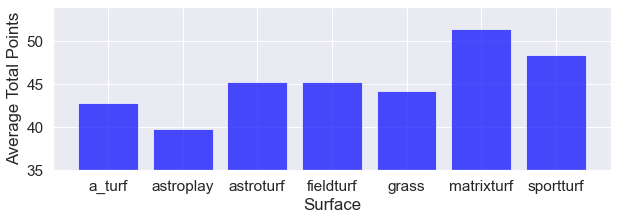

In [831]:
fig10 = plt.figure(figsize=(10,3))
ax = fig10.add_subplot(1,1,1)
ax.set_xlabel('Surface')
ax.set_ylabel('Average Total Points')
ax.set_ylim(35,54)
ax.bar(avg_pts_surf.index,avg_pts_surf.values,color='blue',alpha=0.7)
fig10.show()
fig.savefig('plots/fig95.png')

In [31]:
from scipy.stats import pearsonr

In [212]:
np.corrcoef(by_week['Tot_Pts'],by_week['Week'])

array([[ 1.       , -0.0648166],
       [-0.0648166,  1.       ]])

In [213]:
np.corrcoef(by_week['Tot_Pts'],by_week['Temperature'])

array([[1.        , 0.04835216],
       [0.04835216, 1.        ]])

In [235]:
np.corrcoef(by_week['Temperature'],by_week['Week'])

array([[ 1.        , -0.28474545],
       [-0.28474545,  1.        ]])

In [1278]:
LR.intercept_

45.48882113821139

In [142]:
stad=X_show
stad = pd.concat([stad.drop(['Home_Team','Vis_Team','H_Game','V_Game','Over/Under'],axis=1),
           pd.get_dummies(stad.Home_Team,drop_first=True)],axis=1)

In [165]:
stad.drop('Tot_Pts',axis=1,inplace=True)
scaled_stad = standard.fit_transform(stad)
LR.fit(scaled_stad,y_train)
y_pred = LR.predict(scaled_stad)
results99 = pd.DataFrame(y_train,columns=['Actual'],index=stad.index)
results99['Over/Under'] = X_show.loc[stad.index]['Over/Under']
results99['Predicted'] = y_pred
# Results for small number of features
accuracy99 = ((((results99['Actual']>results99['Over/Under']) & (results99['Predicted']>results99['Over/Under'])) | 
 ((results99['Actual']<results99['Over/Under']) & (results99['Predicted']<results99['Over/Under']))).sum()/
             (results99['Actual']!=results99['Over/Under']).sum())
print(LR.score(scaled_stad,y_train),accuracy99)

0.16188334213190472 0.5814814814814815


In [170]:
coef = pd.DataFrame(LR.coef_, stad.columns, 
                    columns=['LR Coefficient'])
ind=np.flip(np.argsort(abs(LR.coef_)))
coef.iloc[ind[0:40]]

,LR Coefficient
V_Def_Rush,2.426097
V_Off_Pass,2.314361
H_Pts,2.085197
H_Off_Pass,2.026376
sportturf,-1.720495
New Orleans Saints,1.699271
H_Pass_Metric,-1.670293
astroplay,-1.556235
Wind,-1.543468
fieldturf,-1.416436


In [171]:
coef.iloc[ind[40:]]

,LR Coefficient
V_Puntret,0.496899
V_Pts,0.488456
Washington Redskins,0.487934
New York Giants,0.485168
a_turf,0.462975
H_TO_Gain,-0.461749
V_FG_Pct,0.425933
New York Jets,0.420166
Tennessee Titans,0.411146
H_TO_Lost,0.405120


In [173]:
extr=results99[np.abs(results15['Predicted']-results99['Over/Under']) >= 3.0]
print(len(extr)/len(results99))
under_c = ((extr['Actual']<extr['Over/Under']) & (extr['Predicted']<extr['Over/Under'])).sum()
under_t = (extr['Actual']<extr['Over/Under']).sum()
over_c = ((extr['Actual']>extr['Over/Under']) & (extr['Predicted']>extr['Over/Under'])).sum()
over_t = (extr['Actual']>extr['Over/Under']).sum()
print(under_c,under_t,under_c/under_t)
print(over_c,over_t,over_c/over_t)
print(under_c+over_c,under_t+over_t,(under_c+over_c)/(under_t+over_t))

0.4180327868852459
146 236 0.6186440677966102
137 216 0.6342592592592593
283 452 0.6261061946902655


In [198]:
teamcols = list(teams.keys())
teamcols.remove('Arizona Cardinals')
teamcols.remove('Las Vegas Raiders')
for col in teamcols:
    print(col, round(X_show.Tot_Pts.corr(stad[col]),3))

Atlanta Falcons 0.001
Buffalo Bills -0.061
Carolina Panthers 0.004
Chicago Bears -0.03
Cincinnati Bengals 0.015
Cleveland Browns -0.071
Indianapolis Colts -0.009
Dallas Cowboys 0.084
Denver Broncos 0.004
Detroit Lions 0.01
Green Bay Packers 0.036
Houston Texans -0.037
Jacksonville Jaguars -0.024
Kansas City Chiefs -0.073
Miami Dolphins -0.022
Minnesota Vikings 0.004
New Orleans Saints 0.124
New England Patriots 0.065
New York Giants 0.002
New York Jets -0.021
Tennessee Titans 0.0
Philadelphia Eagles -0.005
Pittsburgh Steelers -0.026
Oakland Raiders 0.059
St. Louis Rams -0.03
Los Angeles Rams 0.08
Baltimore Ravens -0.015
San Diego Chargers 0.001
Los Angeles Chargers -0.027
Seattle Seahawks 0.006
San Francisco 49ers -0.041
Tampa Bay Buccaneers -0.0
Washington Redskins 0.018


In [200]:
for col in teamcols:
    print(col, round(X_show.H_Off_Pass.corr(stad[col]),3))

Atlanta Falcons 0.147
Buffalo Bills -0.138
Carolina Panthers -0.064
Chicago Bears -0.068
Cincinnati Bengals -0.029
Cleveland Browns -0.055
Indianapolis Colts 0.043
Dallas Cowboys 0.016
Denver Broncos 0.01
Detroit Lions 0.145
Green Bay Packers 0.078
Houston Texans -0.039
Jacksonville Jaguars -0.07
Kansas City Chiefs -0.058
Miami Dolphins -0.083
Minnesota Vikings -0.082
New Orleans Saints 0.274
New England Patriots 0.163
New York Giants 0.022
New York Jets -0.132
Tennessee Titans -0.091
Philadelphia Eagles 0.045
Pittsburgh Steelers 0.093
Oakland Raiders 0.007
St. Louis Rams -0.13
Los Angeles Rams 0.039
Baltimore Ravens -0.038
San Diego Chargers 0.131
Los Angeles Chargers 0.07
Seattle Seahawks -0.049
San Francisco 49ers -0.101
Tampa Bay Buccaneers 0.038
Washington Redskins -0.031


In [201]:
for col in teamcols:
    print(col, round(X_show.H_Pass_Metric.corr(stad[col]),3))

Atlanta Falcons 0.126
Buffalo Bills -0.072
Carolina Panthers -0.063
Chicago Bears -0.074
Cincinnati Bengals 0.005
Cleveland Browns -0.04
Indianapolis Colts 0.002
Dallas Cowboys -0.015
Denver Broncos 0.003
Detroit Lions 0.122
Green Bay Packers 0.033
Houston Texans -0.034
Jacksonville Jaguars -0.039
Kansas City Chiefs -0.071
Miami Dolphins -0.039
Minnesota Vikings -0.076
New Orleans Saints 0.176
New England Patriots 0.179
New York Giants -0.017
New York Jets -0.105
Tennessee Titans -0.063
Philadelphia Eagles 0.012
Pittsburgh Steelers 0.075
Oakland Raiders 0.006
St. Louis Rams -0.056
Los Angeles Rams 0.016
Baltimore Ravens -0.019
San Diego Chargers 0.107
Los Angeles Chargers 0.076
Seattle Seahawks -0.024
San Francisco 49ers -0.045
Tampa Bay Buccaneers -0.002
Washington Redskins -0.056


In [203]:
for col in teamcols:
    print(col, round(X_show.V_Pts.corr(stad[col]),3))

Atlanta Falcons 0.009
Buffalo Bills -0.029
Carolina Panthers 0.008
Chicago Bears 0.005
Cincinnati Bengals -0.001
Cleveland Browns -0.038
Indianapolis Colts 0.003
Dallas Cowboys 0.054
Denver Broncos 0.037
Detroit Lions -0.033
Green Bay Packers -0.05
Houston Texans -0.015
Jacksonville Jaguars 0.0
Kansas City Chiefs 0.024
Miami Dolphins -0.065
Minnesota Vikings 0.017
New Orleans Saints -0.004
New England Patriots -0.044
New York Giants 0.03
New York Jets -0.003
Tennessee Titans -0.014
Philadelphia Eagles 0.057
Pittsburgh Steelers -0.012
Oakland Raiders 0.028
St. Louis Rams -0.024
Los Angeles Rams 0.09
Baltimore Ravens 0.023
San Diego Chargers 0.034
Los Angeles Chargers -0.046
Seattle Seahawks 0.007
San Francisco 49ers -0.033
Tampa Bay Buccaneers -0.004
Washington Redskins 0.018


In [204]:
from yellowbrick.regressor import ResidualsPlot

ModuleNotFoundError: No module named 'yellowbrick'

In [238]:
domed = X_show[X_show['dome']==1]
notdomed = X_show[X_show['dome']==0]

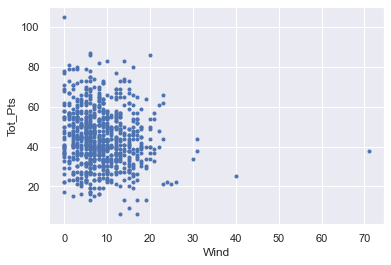

In [239]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
#_ = plt.ylim(0.05,0.15)
_ = plt.plot(notdomed['Wind'],notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

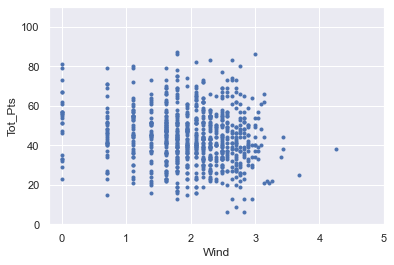

In [270]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.2,5)
_ = plt.ylim(0,110)
_ = plt.plot(np.log(notdomed['Wind']),notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

In [279]:
wadj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 201811110ram to 201412070jax
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   H_Pts           1098 non-null   float64
 1   H_Pts_Opp       1098 non-null   float64
 2   V_Pts           1098 non-null   float64
 3   V_Pts_Opp       1098 non-null   float64
 4   H_Off_Pass      1098 non-null   float64
 5   H_Pass_Metric   1098 non-null   float64
 6   V_Off_Pass      1098 non-null   float64
 7   V_Pass_Metric   1098 non-null   float64
 8   H_Off_Rush      1098 non-null   float64
 9   H_Rush_Metric   1098 non-null   float64
 10  V_Off_Rush      1098 non-null   float64
 11  V_Rush_Metric   1098 non-null   float64
 12  H_Def_Pass      1098 non-null   float64
 13  V_Def_Pass      1098 non-null   float64
 14  H_Def_Rush      1098 non-null   float64
 15  V_Def_Rush      1098 non-null   float64
 16  H_TD_on_Def     1098 non-null   float64
 17  V_TD_on_Def     109

In [317]:
val = wadj[wadj['Wind_adj'] > 0]['Wind_adj'].values
val = np.log(val)
wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'] = val
wadj.loc[wadj['Wind_adj']==0,'Wind_adj'] = wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'].min()
wadj.drop('Wind',axis=1,inplace=True)

In [252]:
X_show['Tot_Pts'].corr(X_show['Wind'])

-0.12121098510402177

In [265]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.log(X_show['Wind']))

-0.13748639619273526

In [343]:
X_show['Tot_Pts'].corr(np.sqrt(X_show['Wind']))

-0.1148841522446934

In [319]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [269]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(1./(X_show['Wind']))

0.13573609073790158

In [320]:
notdomed[notdomed['Wind']>0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [321]:
scaled_train = standard.fit_transform(wadj)
LR.fit(scaled_train,y_train)
y_pred = LR.predict(scaled_train)
results50 = pd.DataFrame(y_train,columns=['Actual'],index=wadj.index)
results50['Over/Under'] = X_show.loc[wadj.index]['Over/Under']
results50['Predicted'] = y_pred
# Results for small number of features
accuracy50 = ((((results50['Actual']>results50['Over/Under']) & (results50['Predicted']>results50['Over/Under'])) | 
 ((results50['Actual']<results50['Over/Under']) & (results50['Predicted']<results50['Over/Under']))).sum()/
             (results50['Actual']!=results50['Over/Under']).sum())
print(LR.score(scaled_train,y_train),accuracy50)

0.1333974002887286 0.5666666666666667


In [ ]:
sns.pairplot(X_train.iloc[:,0:10])

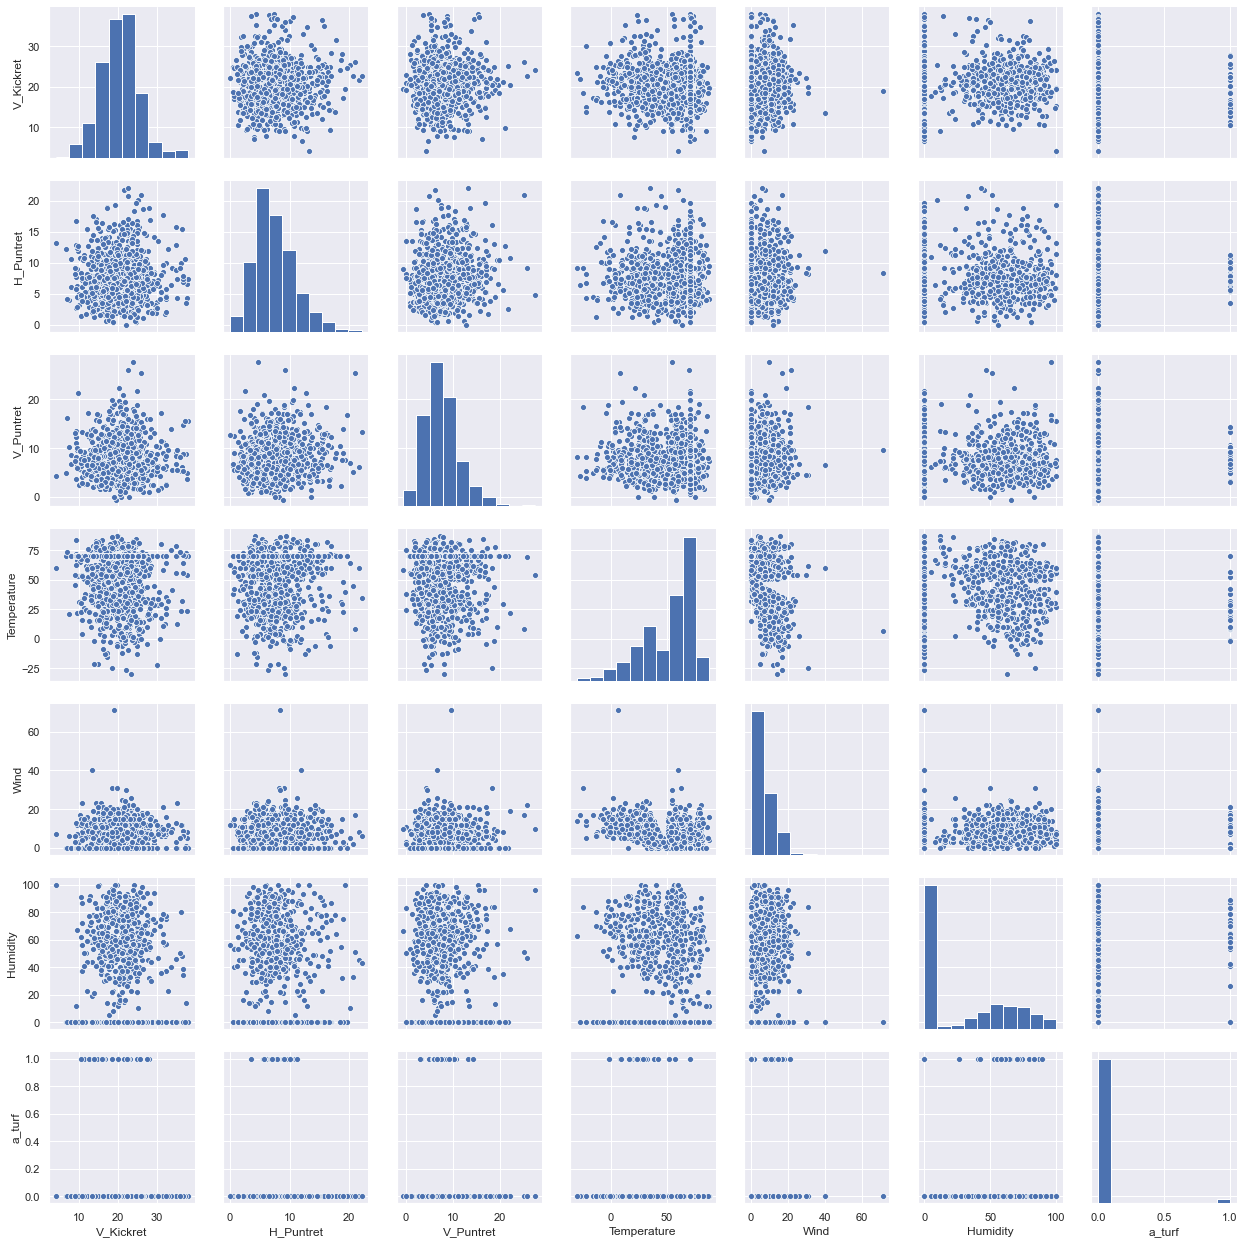

In [367]:
sns.pairplot(X_train.iloc[:,39:46])

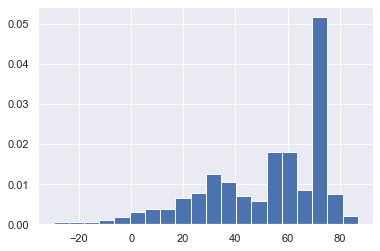

In [371]:
_ = plt.hist(((X_show['Temperature'])),bins=20,density=True)
plt.show()


In [361]:
X_show['Tot_Pts'].corr(np.exp(X_show['Temperature']))

0.0027547525663266597

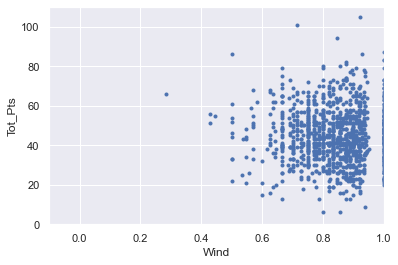

In [365]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.1)
_ = plt.ylim(0,110)
_ = plt.plot((X_show['H_FG_Pct']),X_show['Tot_Pts'],marker='.',linestyle='None')


In [368]:
X_show['Tot_Pts'].corr(X_show['Temperature'])

0.06631800608334214

In [390]:
X_show['Tot_Pts'].mean(),LR.intercept_

(44.888888888888886, 44.888888888888886)

In [436]:
factor=np.arange(0.0,0.75,0.05)
rmse=np.empty(len(factor))
for ind,n in enumerate(factor):
    path = 'data/df_working6_{:.2f}.pkl'.format(n)
    with open(path, 'rb') as f:
        df = pickle.load(f)
    df.dropna(inplace=True)

    X = df.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    y = np.ravel(df['Tot_Pts'])
# 70% split for training data
    wtx_train, wtx_test, wty_train, wty_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
    sc_train = standard.fit_transform(wtx_train)
    sc_test = standard.transform(wtx_test)
    LR.fit(sc_train,wty_train)
    ypred = LR.predict(sc_test)
#    rmse[ind]=mean_squared_error(wty_test,y_pred,squared=False)
    rmse[ind]=np.sqrt(mean_squared_error(wty_test,ypred))
print(rmse)

[13.68722788 13.69967452 13.73890531 13.73165087 13.7496547  13.76771949
 13.78511194 13.78975578 13.81150293 13.83007383 13.84718348 13.8643217
 13.87906164 13.88368748 13.89500563]


In [397]:
round(1.23,3)

1.23

In [411]:
num

0.5

In [469]:
from sklearn.metrics import mean_squared_error
mean_squared_error(wty_test,y_pred,squared=False)

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [471]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.
